## Load data

In [ ]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray
import cdsapi
import urllib3
import cartopy.crs as ccrs
import cartopy

# import powerlaw

analysis_dir = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/'
# roi_pth = '/Volumes/thebe/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp' # for small UAVSAR rois
season = 'jja' # or 'ann'
maxArea = 5000 # km2 include only lakes less than this for calc

###### vars
''' Vars 'dataset', 'roi_region', 'run' are used to generate output filename.'''
###########
# HL vars
dataset = 'HL'
variables = {'id_':'Hylak_id', 'gridcell_':'BAWLDCell_', 'area_':'Shp_Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # Note: need t o join in lat/long
gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
# gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD-NAHL
useROI = False
roi_region = 'BAWLD' #'WBD' # 'Baker' # PAD, Daring, YF
run=10
# roi_pth = '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/WBD_convex_hull.shp' # for WBD roi
areaConversionFactor = 1 # because area already in m2
runNote = 'With ERA5'

################ auto update vars
#################################

## Def output paths
joined_clim_dir = os.path.join(analysis_dir, 'joined_climate', f'run{run:02}')
# summ_file_pth = os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_summ.csv')
# logFile_pth = os.path.join(joined_clim_dir, f'logfile_run{run:02}.txt')

## Make dirs
os.makedirs(joined_clim_dir, exist_ok=True)

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_9142/477152975.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas 

In [137]:
## Load
bawld_dir = '/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/'
df = pd.read_csv(os.path.join(bawld_dir, 'BAWLD_CH4_Aquatic.csv'),
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Add total lake flux column (to match LSD.py)
df['CH4.E.FLUX'].fillna(df['CH4.D.FLUX']*1.2, inplace=True) # Placeholder until I find ratio
df['CH4.D.FLUX'].fillna(df['CH4.E.FLUX']/1.2, inplace=True) # Placeholder until I find ratio
df['CH4.DE.FLUX'] = df['CH4.D.FLUX'] + df['CH4.E.FLUX']

## Filter and pre-process
df.dropna(subset=['SA', 'CH4.DE.FLUX', 'LAT', 'LONG', 'YEAR.S','MONTH'], inplace=True) # 'TEMP'

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)


Filtered out 190 values (363 remaining).
Variables: Index(['ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.DE.FLUX',
       'CH4.D.FLUX.LOG'],
      dtype='object')


,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.DE.FLUX,CH4.D.FLUX.LOG
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,LL,L,NaN,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,8.36,0.681241
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,MLPe,M,Pe,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,189.00,1.892095


## Exploratory data analysis   

### Plot metadata

Text(0.5, 0, 'Mg CH4 / m2 /day')

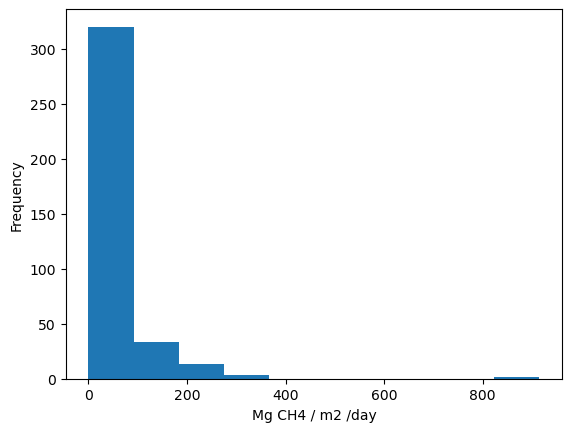

In [107]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

<Axes: xlabel='GRID_T', ylabel='CH4.DE.FLUX'>

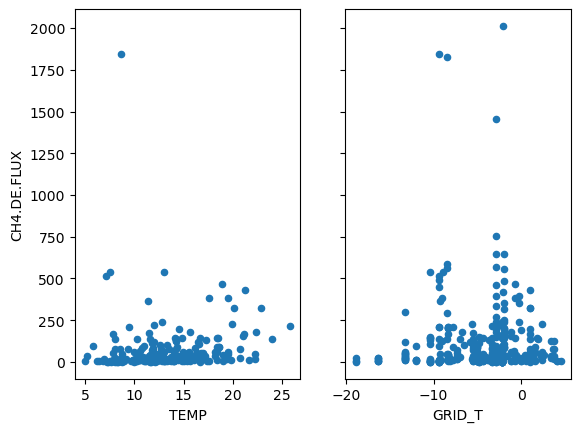

In [108]:
## Plot
_, ax = plt.subplots(1,2, sharey=True)
# df1.plot.scatter(x='TEMP', y='GRID_T')
df.plot.scatter(x='TEMP', y='CH4.DE.FLUX', ax=ax[0])
df.plot.scatter(x='GRID_T', y='CH4.DE.FLUX', ax=ax[1])

In [109]:
## How many missing entries for temp and GRID_T?
np.sum(np.isnan(df.TEMP))
np.sum(np.isin(df.MONTH, ''))
np.sum(np.isnan(df.GRID_T))

5

<Axes: ylabel='Frequency'>

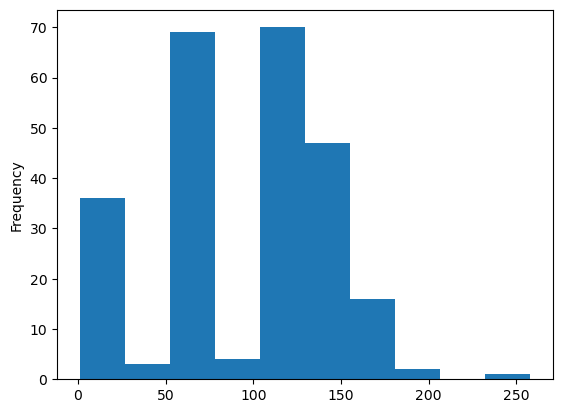

In [110]:
## How long were most studies?
df.LENGTH.plot.hist()

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='D.DAYS', ylabel='Count'>

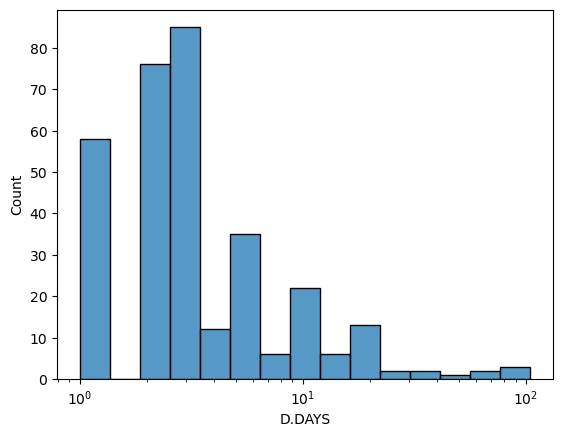

In [111]:
## How many sampling days?
sns.histplot(df, x='D.DAYS', log_scale=10)

.: Most studies lasted < 150 days with <= 3 measurements. So modeled monthly air temp would be hard to compute, unless I take the middle month or average of months.

### Parse years in dataset

In [145]:
## View messy format of years and months
# df[['LAT','LONG']]
df.loc[16:26, ['YEAR.S','MONTH']]

,YEAR.S,MONTH
17,"2013, 2014",July
18,"2013, 2014",July
23,2014-2015,June-September
24,2013-2015,June-September
25,2012-2015,June-September
26,2013-2015,June-September


In [ ]:
def parseYearsMonths(years=None, months=None):
    ''' Helper function that returns a list of years and months (as ints) based on the input format. Years are 4-digit numeric, and months are spelled out. Both can accept ranges or ','or'/'-sep lists '''
    
    ## pre-parse months
    # years=years.replace('/', ',')
    
    years_list = []
    month_dict = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }

    if years is not None:
        for item in years.split(','):
            if '-' in item:
                start, end = list(map(int, item.split('-')))
                years_list.extend([i for i in range(start, end + 1)])
            else:
                years_list.append(int(item.strip()))
    else:
        years_list = None

    if months is not None:
        months=months.replace('/', ',') # pre-parse
        months_list = []
        for item in months.split(','):
            if '-' in item:
                start, end = item.split('-')
                start_month = int(month_dict[start.strip()])
                end_month = int(month_dict[end.strip()])
                months_list.extend([i for i in range(start_month, end_month + 1)])
            else:
                months_list.append(int(month_dict[item.strip()]))
    else:
        months_list = None
            
    ## Convert to int
    # years_list = list(map(int, years_list))
    # months_list = list(map(int, months_list))

    return years_list, months_list 

In [101]:
## Obtain unique years in BAWLD-CH4 after filtering 
yrs = []
for _, r in df.iterrows():
    y, _ = parseYearsMonths(r['YEAR.S'])
    yrs.append(y)

flattened_list = [year for sublist in unq_yrs for year in sublist]
unq_yrs = np.unique(flattened_list)
unq_yrs

array([1988, 1989, 1990, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019])

## Find D vs E ratio: TODO

# Add reannalysis temperatures

## Download climate data using csdapi

In [103]:
# Suppress only InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Use Climate Data Services API
cds = cdsapi.Client()
cds_dir = '/Volumes/thebe/Ch4/ERA5/cds'
cds_pth = os.path.join(cds_dir, "download.netcdf.zip") # test.grib causes xarray loading issues...
# !rm {os.path.join(cds_dir, 'data.nc')} # to avoid unzip question prompt to overwrite

# dataset you want to read
dataset = 'reanalysis-era5-land-monthly-means' # reanalysis-era5-pressure-levels-monthly-means 
years = list(map(str, np.concatenate((unq_yrs, [2022]))))

# api parameters 
params = {
    "format": "netcdf",
    "product_type": "monthly_averaged_reanalysis",
    "variable": ['lake_bottom_temperature', 'skin_temperature', 'soil_temperature_level_4', 'soil_temperature_level_1', '2m_temperature'], # K - 273.15
    'year': years, # 2022
    'month':["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "time": "00:00", 
    'format': 'netcdf.zip', # output.grib
    "grid": [0.25, 0.1], # lon lat
    "area": [90, -180, 50, 180],
    }

In [104]:
# retrieves the path to the file (Can skip this cell)
fl = cds.retrieve(dataset, params, cds_pth)

# load into memory
# with urlopen(fl.location) as f:
#     ds = xr.open_dataset(f.read())

## Unzip and rename
!unzip {cds_pth} -d {cds_dir}
!mv {os.path.join(cds_dir, 'data.nc')} {os.path.join(cds_dir, 'temperatures.nc')}

2023-09-15 15:36:56,436 INFO Welcome to the CDS
2023-09-15 15:36:56,437 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means
2023-09-15 15:36:56,642 INFO Request is queued
2023-09-15 15:36:57,790 INFO Request is running
2023-09-15 15:51:19,337 INFO Request is completed
2023-09-15 15:51:19,340 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data7/adaptor.mars.internal-1694807337.419809-14337-5-1ea493d7-900e-4507-849d-ee7f8b707e97.zip to /Volumes/thebe/Ch4/ERA5/cds/download.netcdf.zip (758.2M)
  0%|          | 0.00/758M [00:00<?, ?B/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2023-09-15 15:57:54,822 INFO Download rate 1.9M/s   


90023.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Archive:  /Volumes/thebe/Ch4/ERA5/cds/download.netcdf.zip
  inflating: /Volumes/thebe/Ch4/ERA5/cds/data.nc  
90040.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [105]:
## Load and view
da = xr.load_dataset(os.path.join(cds_dir, 'temperatures.nc'))
# da = xr.load_dataset(os.path.join(cds_dir, 'test.grib'), engine='cfgrib')

## Info
da

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 401, time: 360)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 1988-01-01 1988-02-01 ... 2022-12-01
Data variables:
    lblt       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    skt        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl4       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl1       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-15 19:48:12 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

Text(0.5, 1.0, 'ERA5 t2m')

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


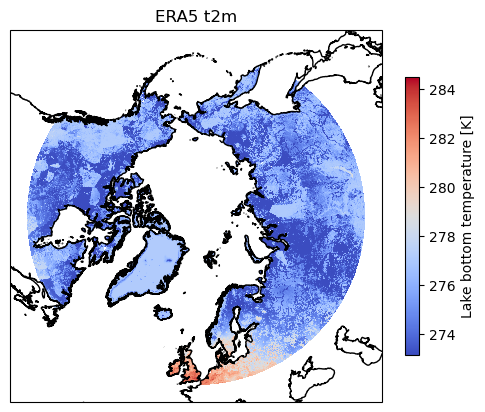

In [110]:
## View
variable = 't2m' # 'lblt' 'skt', 'stl4', 'stl1', 't2m'
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.coastlines(resolution="10m")

da.lblt.sel(time='2022-11-01').plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}) # geographic coords
plt.title(f"ERA5 {variable}")

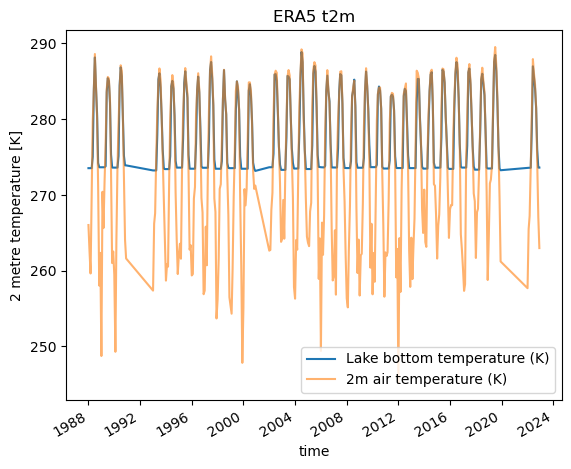

In [259]:
## Time series plot
fig, ax = plt.subplots()
lat, long = [60.460], [-161.450] # works
# lat, long = [66.55], [-164.452] # no data here
da.lblt.sel(latitude=lat, longitude=long, method='nearest').plot(ax=ax, label='Lake bottom temperature (K)') # geographic coords
da.t2m.sel(latitude=lat, longitude=long, method='nearest').plot(ax=ax, label='2m air temperature (K)', alpha=0.6) # geographic coords
ax.set_title(f"ERA5 {variable}")
ax.legend()

In [112]:
## Practice loading from coords
da.lblt.sel(latitude=[60.460], longitude=[-161.450], time='2022-05-01', method='nearest')

<xarray.DataArray 'lblt' (latitude: 1, longitude: 1)>
array([[278.6705]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -161.5
  * latitude   (latitude) float32 60.5
    time       datetime64[ns] 2022-05-01
Attributes:
    units:      K
    long_name:  Lake bottom temperature

## Join in ERA5 temps

In [208]:
def pullTemp(df, da, lat_var='LAT', long_var='LONG', year_var='YEAR.S', month_var='MONTH', var='lblt'):
    '''
    Merges in ERA5 temperature to an array based on 'LAT' and 'LONG' fields.
    
    Parameters
    ----------
    df : pd.DataFrame 
        df with lat, long, year, month fields as named below
    lat : str
        Field name to use for latitude (called "latitude" in ERA5)
    long : str
        Field name to use for longitude (called "longitude" in ERA5)
    year : str
        Field namae to use for year of observation (comes from "time" in ERA5)
    month : str
        Field namae to use for month of observation (comes from "time" in ERA5)
    da : xarray.DataSet
        ERA5 data
    var : str ('lblt)
        One of: 'lblt' 'skt', 'stl4', 'stl1', 't2m'
    
    Returns
    -------
    None

    Function appends new temp field onto dataset fields.
    
    '''

    # Get latitude, longitude, year, and month from the row
    lt = df[lat_var]
    ln = df[long_var]
    # yr_list = parseYears(df[year_var]) # in case a range or list of years
    # mth_list = parseTimes(df[month_var]) # in case a range of months
    yr_list, mth_list = parseYearsMonths(df[year_var], df[month_var])

    
    # Select the temperature data from ERA5 using the given coordinates and time
    # da_tmp = da[var].where(da['time.year'].isin(yr), drop=True).sel(latitude=lt, longitude=ln, method='nearest')

    # temprs = [] # init
    # for yr in yr_list:
    #     temprs.append(da[var].sel(
    #         time = slice(f'{yr}-{mth_list[0]}-01', f'{yr}-{mth_list[-1]}-01')).sel(
    #             latitude=lt, longitude=ln, method='nearest').mean())
    
    temprs = da[var].sel(latitude=lt, longitude=ln, method='nearest').sel(time=(da['time.year'].isin(yr_list)) & (da['time.month'].isin(mth_list)))

    ## reduce
    tempr = temprs.mean()

    # Add the temperature data to the row as a new field
    df = df.copy() # TODO: inefficient bc copies lots of columns I don't need... still works though
    df.loc[f'ERA5_{var}'] = tempr.values # to avoid setting value on slice warning (SettingWithCopyWarning)
    return df


# def parseTimes(tm):
#     ''' Helper function that returns the string unchanged if it does not contain '-' (e.g. 'September'). Otherwise, returns a list of months that were separated by '-'. '''
#     tm = str(tm)
#     if '-' in tm:
#         output = tm.split('-')
#     else:
#         output =  [tm]
#     if tm[0].isnumeric():
#         return list(map(int, output))
#     else:
#         return output

# def parseYears(tm):
#     ''' Helper function that returns the string unchanged if it does not contain '-' or ',' (e.g. '2010'). Otherwise, returns a list of years that were separated by ',' or the years from a range that was separated by a '-'. '''
#     years_list = []
    
#     for item in tm.split(','):
#         if '-' in item:
#             start, end = item.split('-')
#             years_list.extend([str(i) for i in range(int(start), int(end) + 1)])
#         else:
#             years_list.append(item.strip())
    
#     return years_list

In [220]:
## Apply with apply
df_era5 = df.copy()
tvars = ['lblt', 'skt', 'stl4', 'stl1', 't2m']
for tvar in tvars:
    # df_era5 = df.apply(pullTemp, args=(da,'LAT', 'LONG', 'YEAR.S', 'MONTH', tvar), axis=1)
    # df_era5 = df.apply(lambda row: pullTemp(row, da, var=tvar), axis=1)
    df_era5[f'ERA5_{tvar}'] = df.apply(lambda row: pullTemp(row, da, var=tvar), axis=1)[f'ERA5_{tvar}']
    df_era5[f'ERA5_{tvar}'] = df_era5[f'ERA5_{tvar}'].astype('float') # to avoid type being 'object'

df_era5.head()

## Test on one row
# df1=df.iloc[23,:]
# pullTemp(df1, da)



,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,GRID_T,NOTES,DOI,CH4.DE.FLUX,CH4.D.FLUX.LOG,ERA5_lblt,ERA5_skt,ERA5_stl4,ERA5_stl1,ERA5_t2m
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,8.36,0.681241,286.165161,287.401459,275.091309,287.020081,286.538513
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,189.00,1.892095,286.165161,287.401459,275.091309,287.020081,286.538513
2,3,1,Bartlett et al. 1992,WIK,1992,USA,CHAOS,1.0,60.46,-161.45,...,-0.006,NaN,https://doi.org/10.1029/91JD00610,4.40,0.477121,286.165161,287.401459,275.091309,287.020081,286.538513
17,18,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL 66,1.0,73.09,-79.58,...,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,3.84,0.387390,276.597412,282.751709,267.084839,281.298035,279.319702
18,19,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL80,1.0,73.09,-79.58,...,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,24.32,0.976808,276.597412,282.751709,267.084839,281.298035,279.319702


In [188]:
## Write out

df_era5.to_csv(os.path.join(bawld_dir, 'BAWLD_CH4_Aquatic_ERA5.csv'))


# BAWLD regression

In [211]:
## Filter out data with nans near coast with no ERA5-land data

df_era5.dropna(subset=['ERA5_lblt'], inplace=True) # 'TEMP'

## Initial tests with builtin data

In [212]:
## Linear models (regression) v0
formula1 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula1, data=df_era5).fit() # uses water temp
formula2 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + GRID_T" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model2 = ols(formula=formula2, data=df_era5).fit() # uses MAAT
formula3 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + np.power(TEMP, 2)" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model3 = ols(formula=formula3, data=df_era5).fit() # uses MAAT

# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.128
Model:                                           OLS   Adj. R-squared:                  0.121
Method:                                Least Squares   F-statistic:                     16.50
Date:                               Fri, 15 Sep 2023   Prob (F-statistic):           2.06e-07
Time:                                       17:49:37   Log-Likelihood:                -236.32
No. Observations:                                227   AIC:                             478.6
Df Residuals:                                    224   BIC:                             488.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4906      0.161      3.046      0.003       0.173       0.808
np.log10(SA)    -0.0633      0.038     -1.676      0.095      -0.138       0.011
TEMP             0.0597      0.011      5.192      0.000       0.037       0.082
==============================================================================
Omnibus:                       79.166   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.572
Skew:                          -1.238   Prob(JB):                     7.88e-97
Kurtosis:                       9.376   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Additional models with ERA5 temps

In [258]:
## Try with reannalysis temps

m5_models = {}
for i, tvar in enumerate(tvars):
    formula = f"np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + ERA5_{tvar}"
    m5_models[f'model{i+4}'] = ols(formula=formula, data=df_era5).fit()

{'model4': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x29538d010>,
 'model5': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2955f88d0>,
 'model6': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x295387050>,
 'model7': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x29560b8d0>,
 'model8': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x295615e10>}

In [234]:
## Compare model using water temp vs MAAT. First column is after filtering by TEMP and ice-free. Second column is without and shows less difference bw variable.
model1.rsquared # 0.115 # 0.106 # water temp
model2.rsquared # 0.046 # 0.109 # MAAT
model3.rsquared # 0.116 # 0.108 # water temp squared - hardly an improvement! Justification for linear.
# TODO: model that uses monthly or daily air temp!

0.1284539752855337

In [295]:
## Record regression results in a table

models = [model1, model2, model3] + [m5_models[f'model{n}'] for n in range(4,9)]
notes = ['water temp', 'MAAT', 'Water temp squared', 'Modeled lake bottom T', 'Modeled skin T', 'Modeled soil T level 4','Modeled soil T level 1','2m air T']
model_names = [f'model{n}' for n in range(1,9)]
rsq = [model.rsquared for model in models]
eqn = [f"y = {model.params['Intercept']:.2f} + {model.params.iloc[1]:.2f}*{model.params.index[1]} + {model.params.iloc[2]:.2f}*{model.params.index[2]}" for model in models]
pval_1 = [model.pvalues.iloc[1] for model in models]
pval_2 = [model.pvalues.iloc[2] for model in models]

model_summ = pd.DataFrame({'Model Name': model_names, 'R-Squared': rsq, 'P (SA)': pval_1, 'P (Temp)': pval_2, 'Equation':eqn, 'Note': notes})
model_summ.sort_values('R-Squared', ascending=False)


,Model Name,R-Squared,P (SA),P (Temp),Equation,Note
6,model7,0.220548,6.234585e-09,1.340103e-11,y = -16.10 + -0.18*np.log10(SA) + 0.06*ERA5_stl1,Modeled soil T level 1
7,model8,0.213699,3.829168e-08,6.475748e-11,y = -10.04 + -0.18*np.log10(SA) + 0.04*ERA5_t2m,2m air T
4,model5,0.203249,1.421529e-08,7.012647e-10,y = -8.66 + -0.18*np.log10(SA) + 0.03*ERA5_skt,Modeled skin T
5,model6,0.154894,4.054130e-09,3.281744e-05,y = -15.55 + -0.19*np.log10(SA) + 0.06*ERA5_stl4,Modeled soil T level 4
3,model4,0.145528,2.229945e-11,2.567670e-04,y = -13.15 + -0.22*np.log10(SA) + 0.05*ERA5_lblt,Modeled lake bottom T
2,model3,0.128454,9.313499e-02,4.646928e-07,y = 0.88 + -0.06*np.log10(SA) + 0.00*np.power(...,Water temp squared
0,model1,0.128423,9.515962e-02,4.666190e-07,y = 0.49 + -0.06*np.log10(SA) + 0.06*TEMP,water temp
1,model2,0.120289,5.310186e-11,1.090072e-01,y = 1.10 + -0.22*np.log10(SA) + 0.02*GRID_T,MAAT


In [296]:
## Write out

model_summ.to_csv(os.path.join(bawld_dir, 'Regression_table.csv'))

In [287]:
## View best model

m5_models['model7'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.221
Model:                                           OLS   Adj. R-squared:                  0.216
Method:                                Least Squares   F-statistic:                     49.94
Date:                               Fri, 15 Sep 2023   Prob (F-statistic):           7.96e-20
Time:                                       18:50:44   Log-Likelihood:                -440.61
No. Observations:                                356   AIC:                             887.2
Df Residuals:                                    353   BIC:                             898.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -16.0989      2.450     -6.572      0.000     -20.917     -11.281
np.log10(SA)    -0.1838      0.031     -5.956      0.000      -0.245      -0.123
ERA5_stl1        0.0610      0.009      6.995      0.000       0.044       0.078
==============================================================================
Omnibus:                       91.907   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.744
Skew:                          -1.139   Prob(JB):                     2.22e-65
Kurtosis:                       6.858   Cond. No.                     1.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""